# Import Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import unicodedata
import re
!pip install tensorflow
import tensorflow as tf
import pandas as pd
!pip install tensorflow_datasets
import tensorflow_datasets as tfds

# LOADING THE DATA


In [3]:
movie_lines_features = ["LineID", "Character", "Movie", "Name", "Line"]
movie_lines = pd.read_csv("movie_lines.txt", sep = "\+\+\+\$\+\+\+", engine = "python", index_col = False,
                          names = movie_lines_features)

# Using only the required columns, namely, "LineID" and "Line"
movie_lines = movie_lines[["LineID", "Line"]]

# Strip the space from "LineID" for further usage and change the datatype of "Line"
movie_lines["LineID"] = movie_lines["LineID"].apply(str.strip)
movie_lines = {k:v for k, v in zip(movie_lines["LineID"], movie_lines["Line"])}

In [4]:
movie_conversations_features = ["Character1", "Character2", "Movie", "Conversation"]

movie_conversations = pd.read_csv("movie_conversations.txt", sep = "\+\+\+\$\+\+\+", engine = "python",
                                  index_col = False, names = movie_conversations_features)


def movie_key(sent):
    sent = [i for i in sent.split("\'") if len(i) > 2]
    return sent



# Again using the required feature, "Conversation"
movie_conversations = movie_conversations["Conversation"].apply(lambda x:movie_key(x))

In [5]:
movie_conversations.head()

0    [L194, L195, L196, L197]
1                [L198, L199]
2    [L200, L201, L202, L203]
3          [L204, L205, L206]
4                [L207, L208]
Name: Conversation, dtype: object

# Extract into pair

In [6]:
questions = []
answers = []

for conver in list(movie_conversations):        
    for i in range(len(conver) - 1):
        context = movie_lines[conver[i]]
        response = movie_lines[conver[i+1]]
        questions.append(str(context))
        answers.append(str(response))


In [7]:
# Function for plotting histogram
def plothist(sizes):
    print(f"Minimum line size = {min(sizes)}\nMaximum line size = {max(sizes)}")
    _ = plt.hist(sizes, range(0, 250))
    plt.xlabel('Sentence Length', fontsize=15)
    plt.ylabel('Number of Occurences', fontsize=15)
    plt.title('Length Distribution', fontsize=25)
    plt.show()

Minimum line size = 2
Maximum line size = 1904


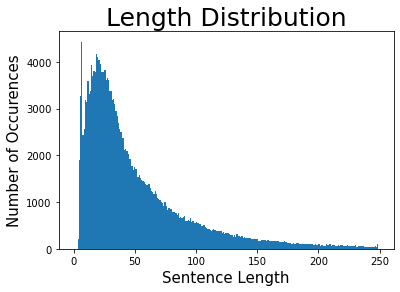

In [8]:
line_sizes = [len(line) for line in questions]
plothist(line_sizes)

# Data Cleaning

In [9]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # removing contractions
    sentence = re.sub(r"i'm", "i am", sentence)
    sentence = re.sub(r"he's", "he is", sentence)
    sentence = re.sub(r"she's", "she is", sentence)
    sentence = re.sub(r"it's", "it is", sentence)
    sentence = re.sub(r"that's", "that is", sentence)
    sentence = re.sub(r"what's", "that is", sentence)
    sentence = re.sub(r"where's", "where is", sentence)
    sentence = re.sub(r"how's", "how is", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can't", "cannot", sentence)
    sentence = re.sub(r"n't", " not", sentence)
    sentence = re.sub(r"n'", "ng", sentence)
    sentence = re.sub(r"'bout", "about", sentence)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence


def load_conversations(Q, A):
    inputs, outputs = [], []
    for i in range(len(Q)):
        inputs.append(preprocess_sentence(Q[i]))
        outputs.append(preprocess_sentence(A[i]))
    return inputs, outputs


questions, answers = load_conversations(questions, answers)

In [10]:
print('Sample question: {}'.format(questions[20]))
print('Sample answer: {}'.format(answers[20]))

Sample question: i really , really , really wanna go , but i cannot . not unless my sister goes .
Sample answer: i am working on it . but she does not seem to be going for him .


# Tokenize && Padding

In [11]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
            questions + answers, target_vocab_size=2**13)

# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2

In [12]:
#### Save Tokenizer

tokenizer.save_to_file("Tokenizer")
### encoder = tfds.deprecated.text.SubwordTextEncoder.load_from_file(vocab_fname)

In [13]:
print('Tokenized sample question: {}'.format(tokenizer.encode(questions[20])))

Tokenized sample question: [4, 303, 2, 303, 2, 150, 397, 180, 2, 41, 4, 549, 3, 11, 907, 32, 1453, 3251, 1]


In [14]:
# Maximum Sentences length
MAX_LENGTH = 40


# Tokenize, filter and pad sentences
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        # tokenize sentence
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        # check tokenized sentence max length
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
    # pad tokenized sentences
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
    tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
    tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
    return tokenized_inputs, tokenized_outputs


questions, answers = tokenize_and_filter(questions, answers)

In [15]:
print('Vocab size: {}'.format(VOCAB_SIZE))
print('Number of samples: {}'.format(len(questions)))

Vocab size: 8241
Number of samples: 194603


# Dataset finalize

In [16]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# decoder inputs use the previous target as input
# remove START_TOKEN from targets
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [17]:
print(dataset)

<PrefetchDataset shapes: ({inputs: (None, 40), dec_inputs: (None, 39)}, {outputs: (None, 39)}), types: ({inputs: tf.int32, dec_inputs: tf.int32}, {outputs: tf.int32})>


# MODEL(Transformer)

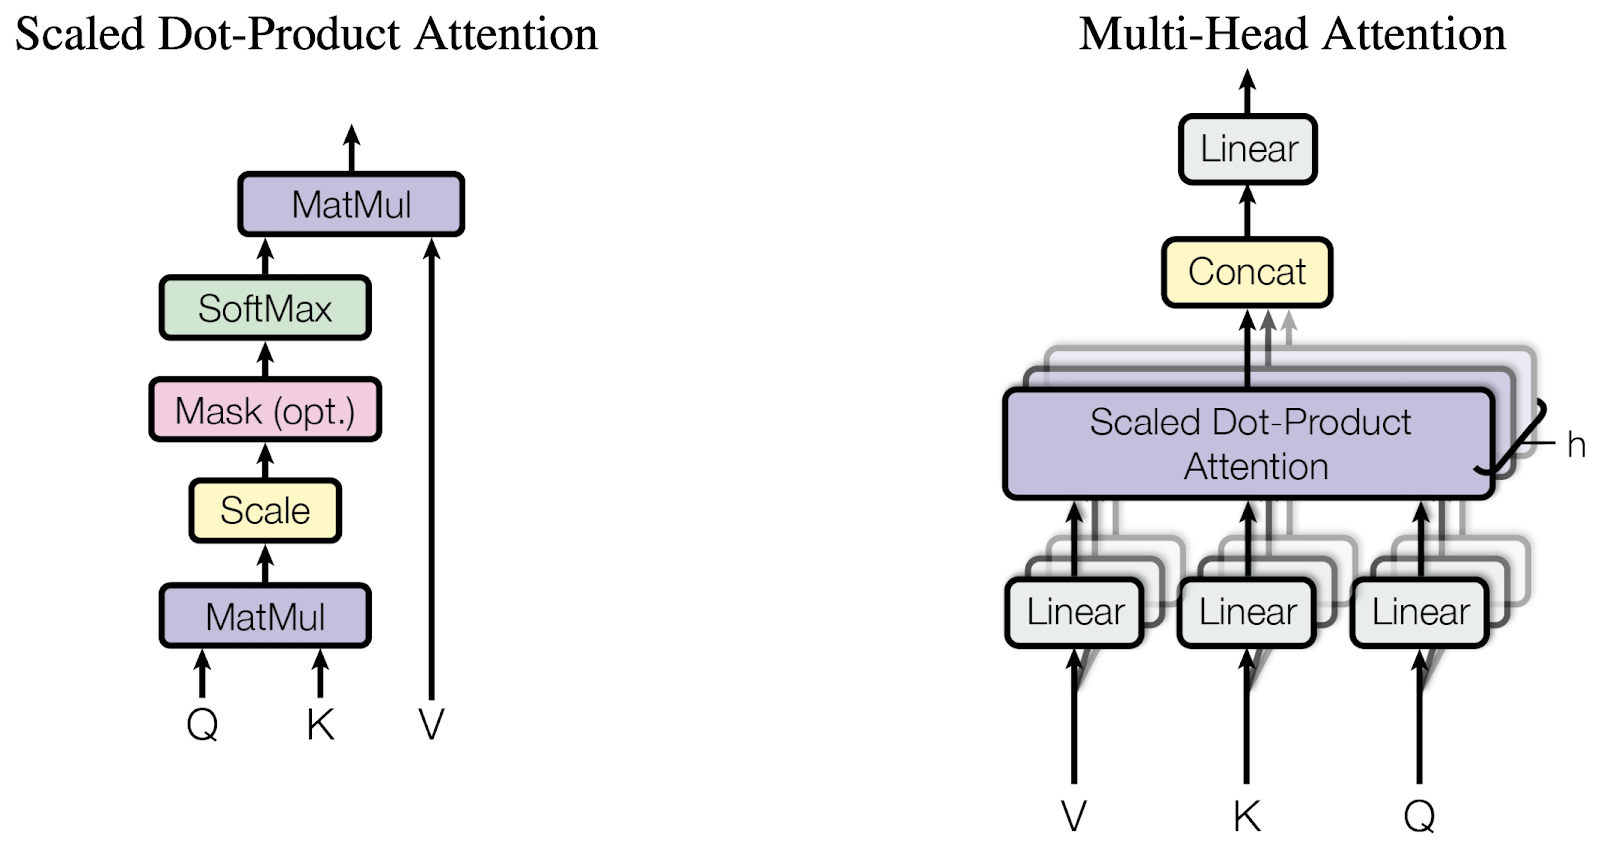

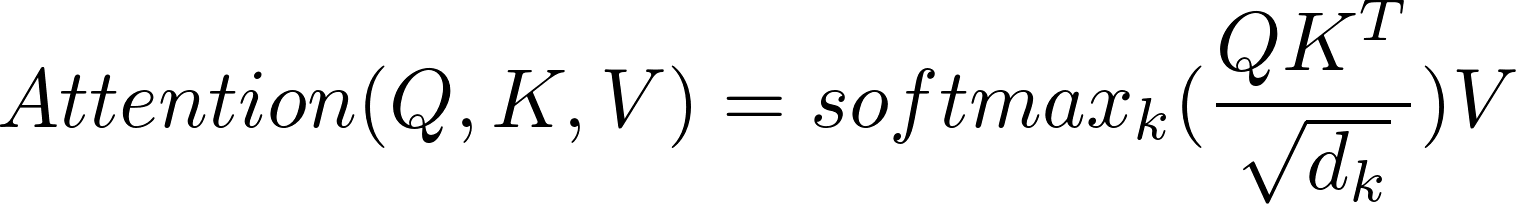

# Scaled dot product attention

In [18]:
def scaled_dot_product_attention(query, key, value, mask):
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # add the mask zero out padding tokens.
    if mask is not None:
        logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(logits, axis=-1)

    return tf.matmul(attention_weights, value)

# Multi-head Attention Layer

In [19]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # split heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        outputs = self.dense(concat_attention)

        return outputs

# Transformer

######                                    Transformer architecture diagram from Attention 

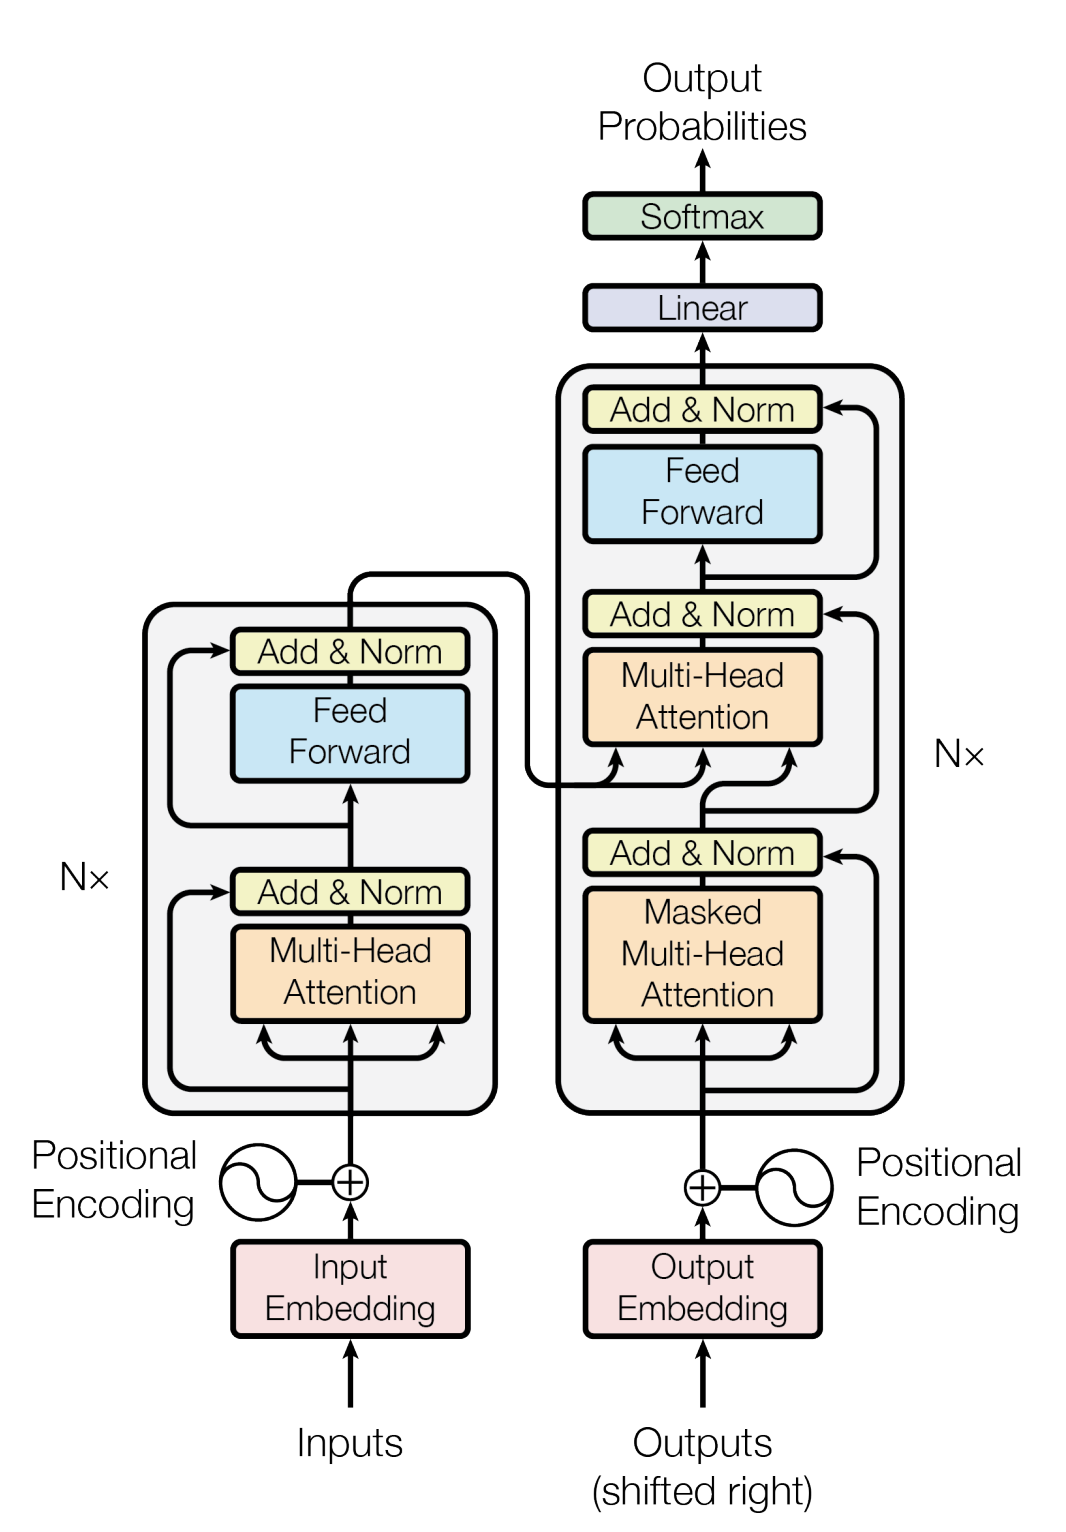

In [20]:
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1


### Masking

`create_padding_mask` and `create_look_ahead` are helper functions to creating masks to mask out padded tokens, we are going to use these helper functions as `tf.keras.layers.Lambda` layers.

Mask all the pad tokens (value `0`) in the batch to ensure the model does not treat padding as input.

In [21]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [22]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


Look-ahead mask to mask the future tokens in a sequence.
We also mask out pad tokens.

i.e. To predict the third word, only the first and second word will be used

In [23]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [24]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


### Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [25]:
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

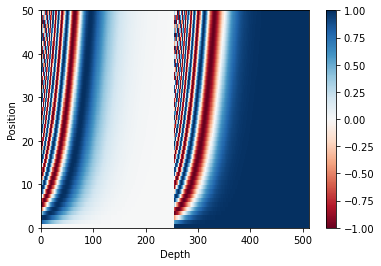

In [26]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Encoder Layer

Each encoder layer consists of sublayers:

1. Multi-head attention (with padding mask) 
2. 2 dense layers followed by dropout

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

In [27]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention = MultiHeadAttention(
                                      d_model, num_heads, name="attention")({
                                          'query': inputs,
                                          'key': inputs,
                                          'value': inputs,
                                          'mask': padding_mask
                                      })
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [28]:
sample_encoder_layer = encoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder_layer")

tf.keras.utils.plot_model(
    sample_encoder_layer, to_file='encoder_layer.png', show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


## Encoder

The Encoder consists of:
1.   Input Embedding
2.   Positional Encoding
3.   `num_layers` encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [29]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [30]:
sample_encoder = encoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder")

tf.keras.utils.plot_model(
   sample_encoder, to_file='encoder.png', show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


## Decoder Layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). `value` and `key` receive the *encoder output* as inputs. `query` receives the *output from the masked multi-head attention sublayer.*
3.   2 dense layers followed by dropout

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

As `query` receives the output from decoder's first attention block, and `key` receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [31]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
                      shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    attention1 = MultiHeadAttention(
          d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
          })
    attention1 = tf.keras.layers.LayerNormalization(
                epsilon=1e-6)(attention1 + inputs)

    attention2 = MultiHeadAttention(
          d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
          })
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
                  epsilon=1e-6)(attention2 + attention1)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
          epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
              inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
              outputs=outputs,
              name=name)

In [32]:
sample_decoder_layer = decoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder_layer")

tf.keras.utils.plot_model(
    sample_decoder_layer, to_file='decoder_layer.png', show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


## Decoder

The Decoder consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers


The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [33]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
                      shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
          inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
          outputs=outputs,
          name=name)

In [34]:
sample_decoder = decoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder")

tf.keras.utils.plot_model(
    sample_decoder, to_file='decoder.png', show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


### Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [35]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    enc_padding_mask = tf.keras.layers.Lambda(
                        create_padding_mask, output_shape=(1, 1, None),
                        name='enc_padding_mask')(inputs)
    # mask the future tokens for decoder inputs at the 1st attention block
    look_ahead_mask = tf.keras.layers.Lambda(
                                      create_look_ahead_mask,
                                      output_shape=(1, None, None),
                                      name='look_ahead_mask')(dec_inputs)
    # mask the encoder outputs for the 2nd attention block
    dec_padding_mask = tf.keras.layers.Lambda(
                                      create_padding_mask, output_shape=(1, 1, None),
                                      name='dec_padding_mask')(inputs)

    enc_outputs = encoder(
                  vocab_size=vocab_size,
                  num_layers=num_layers,
                  units=units,
                  d_model=d_model,
                  num_heads=num_heads,
                  dropout=dropout,
                )(inputs=[inputs, enc_padding_mask])

    dec_outputs = decoder(
                  vocab_size=vocab_size,
                  num_layers=num_layers,
                  units=units,
                  d_model=d_model,
                  num_heads=num_heads,
                  dropout=dropout,
                )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [36]:
sample_transformer = transformer(
    vocab_size=8192,
    num_layers=4,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_transformer")

tf.keras.utils.plot_model(
    sample_transformer, to_file='transformer.png', show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


# Train model

## Loss function

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [37]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

### Custom learning rate

Use the Adam optimizer with a custom learning rate

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

In [38]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
    
        self.d_model = tf.constant(d_model,dtype=tf.float32)
        self.warmup_steps = warmup_steps
    
    
    def get_config(self):
        return {"d_model": self.d_model,"warmup_steps":self.warmup_steps}
    
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.multiply(tf.math.rsqrt(self.d_model), tf.math.minimum(arg1, arg2))

Text(0.5, 0, 'Train Step')

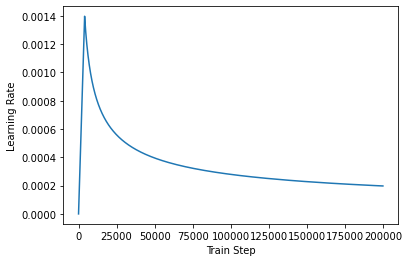

In [39]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### Initialize and compile model

Initialize and compile model with our predefined custom learning rate and Adam optimizer under the strategy scope.

In [40]:
# clear backend

NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1
EPOCHS = 40


tf.keras.backend.clear_session()

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    # ensure labels have shape (batch_size, MAX_LENGTH - 1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

# initialize and compile model within strategy scope
model = transformer(vocab_size=VOCAB_SIZE,
                    num_layers=NUM_LAYERS,
                    units=UNITS,
                    d_model=D_MODEL,
                    num_heads=NUM_HEADS,
                    dropout=DROPOUT)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3163904     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### Fit model

Train our transformer by simply calling `model.fit()`

In [ ]:
model.fit(dataset, epochs=EPOCHS)

Epoch 1/40
 804/3041 [======>.......................] - ETA: 1:58:40 - loss: 2.0548 - accuracy: 0.0455

In [ ]:
# path = "model/chatbot"
# model.save_weights(path)
# # new_model = tf.keras.models.load_weights("model/")

In [ ]:
# new_model = transformer(
#             vocab_size=VOCAB_SIZE,
#             num_layers=NUM_LAYERS,
#             units=UNITS,
#             d_model=D_MODEL,
#             num_heads=NUM_HEADS,
#             dropout=DROPOUT)
# new_model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
# print(new_model.summary())
# new_model.load_weights(path)

## Evaluate and predict

The following steps are used for evaluation:

* Apply the same preprocessing method we used to create our dataset for the input sentence.
* Tokenize the input sentence and add `START_TOKEN` and `END_TOKEN`. 
* Calculate the padding masks and the look ahead masks.
* The decoder then outputs the predictions by looking at the encoder output and its own output.
* Select the last word and calculate the argmax of that.
* Concatentate the predicted word to the decoder input as pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.

Note: The model used here has less capacity and trained on a subset of the full dataset, hence its performance can be further improved.

In [ ]:
#model.load_weights("model/")

In [ ]:
def evaluate(sentence):
    sentence = preprocess_sentence(sentence)

    sentence = tf.expand_dims(
                  START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    output = tf.expand_dims(START_TOKEN, 0)

    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output], training=False)

        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

    # concatenated the predicted_id to the output which is given to the decoder as its input.
    output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)

def predict(sentence):
    prediction = evaluate(sentence)
    predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])
    return predicted_sentence

In [ ]:
output = predict('Where have you been?')
output

In [ ]:
output = predict("It's a trap")
output

In [ ]:
# feed the model with its previous output
sentence = 'I am not crazy, my mother had me tested.'
for _ in range(5):
    sentence = predict(sentence)
    print(sentence)